# Лабораторная работа №1 «Численное решение дифференциальных уравнений»



## Вступление

В первой лабораторной Вашей задачей будет изучить и реализовать различные методы для численного решения дифференциальных уравнений.

Наверное, из курса физики Вы успели заметить, что дифференциальные уравнения появляются при описании явлений современного мира практически повсеместно, и практически никогда эти уравнения невозможно разрешить даже в квадратурах (выразив $y(x)$ через элементарные функции и интегралы от них).

Однако, физическими задачами уже никого не удивить, а уравнение движения маятника Вам уже, наверное, набило оскомину. Да и складывающееся ощущение, что дифференциальные уравнения возникают только лишь в задачах естествознания, ошибочно. Чтобы показать это, в качестве задачи в данной лабораторной работе рассматривается интересный пример использования дифференциальных уравнений в задачах искусственного интеллекта. *Неожиданно?!* Давайте разбираться.

## Задание 1. Численное решение дифференциального уравнения первого порядка.

Прежде чем приступить к интеллекту искусственному, применим интеллект естественный для реализации функций численного решения дифференциальных уравнений.


### Описание задачи

Так как дальше нам понадобится решать систему уравнений, то сразу будем решать задачу Коши
$$
\begin{cases} x(t)' = f(t, x(t)),\\ x(t_0) = x_0 \end{cases} \quad \text{где } x,x_0 \in \mathbb{R}^n, \ t \in [t_0,T].
$$

Рассмотрим два, наверное, самых распространенных метода:
- Метод ломаных Эйлера,
- Метод Рунге—Кутты.

Импортируем необходимые нам далее библиотеки.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Метод ломаных Эйлера

Метод Эйлера — это канонический и, честно говоря, простейший численный метод для решения дифференциальных уравнений. Мы будем искать приближение решения в виде ломаной. Для того, чтобы построить ломаную, нужно найти координаты ее вершин, этим и займемся.



##### Теоретические выкладки

Зададим на отрезке $[t_0, T]$ некоторое разбиение $\big\{t_m\big\}_{m=0}^M$.

Пусть $\varphi(t)$ — истинное решение. Разложим функцию$^*$ $\varphi(t)$ по Тейлору в точке $t_k ,\;  k \in \{0,1,\dots,M-1\}$:
$$
\varphi(t) = \varphi(t_k) + (t-t_k)\cdot \varphi'(t_k) + \mathrm{\overline o}\left(t-t_k\right).
$$
Подставим $t=t_{k+1}$:
$$
\varphi(t_{k+1}) = \varphi(t_k) + (t_{k+1}-t_k)\cdot \varphi'(t_k)  + \mathrm{\overline o}\left(t_{k+1}-t_k \right).
$$
Обозначим $h_k = t_{k+1} - t_k$ и обрубим наше разложение, отбросив о-малое. Тогда
$$
\psi(t_{k+1}) = \varphi(t_k) + h_k \cdot \varphi'(t_k)
$$
— приближенное значение $\varphi(t_{k+1})$, $\psi(t_0) = x_0$.

Так как $\varphi(t)$ — решение уравнения $x'=f(t,x)$, то $\varphi'(t) = f(t, \varphi(t))$, а значит
$$
\psi(t_{k+1}) = \varphi(t_k) + h_k \cdot f(t_k, \varphi(t_k)).
$$
Так как $\psi(t_k)$ — приближенное значение $\varphi (t_k)$, то, с некоторой потерей точности, в правой части можем заменить все $\varphi(t_k)$ на $\psi(t_k)$.

Тогда получаем множество упорядоченных вершин ломаной Эйлера:
$$\boxed{\psi(t_{k+1}) = \psi(t_k) + h_k \cdot f(t_k, \psi(t_k)), \quad \psi(t_0) = x_0}$$

Тогда для построения приближенного решения задачи Коши достаточно запустить вычисление вплоть до $\psi(t_M)$.

Более подробно, а именно: то, почему метод сходится, какая погрешность получается и т.д., обсуждалось на практических занятиях.

<sub>* В случае, когда у нас система уравнений, то есть $x$ является вектором, просто проделываем данные рассуждения  покомпонентно.</sub>

##### Реализация метода

Реализуйте метод ломаных Эйлера для задачи Коши
$$
\begin{cases}
x'(t) = f(t, x(t)),\\
x(t_0) = x_0,\\
t\in [t_0, T].
\end{cases}
$$
в функции `Euler_method`, принимающей в качестве аргументов:
- `fun` — функция, задающая правую часть уравнения,
- `t` — список с границами отрезка — список $[t_0, T]$,
- `x_0` — вектор$_{(n\times 1)}$ начального значения при $t=t_0$,
- `dt` — величина $h_k$ (для простоты примем разбиение равномерным),
- `args` — словарь с аргументами для функции `fun` (в Python можно передавать в аргументы функции словарь [с помощью оператора `**` перед словарем](https://stackoverflow.com/questions/334655/passing-a-dictionary-to-a-function-as-keyword-parameters)),

и возвращающей список с первой координатой — массивом с точками разбиения $t_k$, а второй — массивом со значениями приближенного решения в этих точках.

In [3]:
'''
Реализация метода ломаных Эйлера в функции Euler_method
'''

def euler_method(fun, t, x_0, dt, args={}):
    t_points = np.clip(np.arange(t[0], t[1] + dt, dt), t[0], t[1])
    
    x_points = np.zeros((len(t_points), len(x_0)))
    x_points[0] = x_0
    
    for i in range(1, len(t_points)):
        x_points[i] = x_points[i-1] + dt * fun(t_points[i-1], x_points[i-1], **args)
    
    return t_points, x_points

#### Метод Рунге-Кутты

Теперь рассмотрим не столько геометрически понятный, но достаточно часто применяемый на практике метод Рунге—Кутты, ограничившись лишь вторым порядком последнего.

##### Теоретические выкладки

Так как $\varphi$ — решение исходной задачи Коши, то $\varphi'(t) = f(t, \varphi(t))$, а также
$$
\varphi''(t) = \frac{d}{d t} f(t, \varphi(t)) = \frac{\partial f(t, \varphi)}{\partial t} + \frac{\partial f(t, \varphi)}{\partial \varphi} \frac{d\varphi(t)}{dt}= \frac{\partial f(t, \varphi)}{\partial t} + \frac{\partial f(t, \varphi)}{\partial \varphi} f(t,\varphi(t)).
$$

Аналогично тому, что делали ранее, воспользуемся разложением Тейлора на отрезке в точке $t_k$ и подставим точку $t_{k+1}$:
$$
\varphi(t_{k+1}) = \varphi(t_k) + (t_{k+1}-t_k)\cdot \varphi'(t_k) + \frac{1}{2}(t_{k+1}-t_k)^2\cdot \varphi''(t_k) + \mathrm{\overline o}\left((t_{k+1}-t_k)^2\right).
$$
Отбросим слагаемое с о-малым, тем самым переходя к приближению $\psi$ функции $\varphi$; подставим выражения для $\varphi'$, $\varphi''$. Получим
$$
\psi(t_{k+1}) = \psi(t_k) + (t_{k+1}-t_k)\cdot f(t_k, \psi(t_k)) + \frac{1}{2}(t_{k+1}-t_k)^2\cdot \left.\left(f'_t(t, \psi) + f'_\psi(t, \psi) f(t,\psi(t))\right)\right|_{(t_k, \psi(t_k))}. \tag{o}
$$

Запишем теперь разложение Тейлора функции двух переменных $f(t,\psi)$ в точке $(t_k, \psi(t_k))$ и подставим точку $\big(t_{k}+\alpha (t_{k+1} - t_k), \psi(t_{k})+ \alpha(t_{k+1}-t_k)f(t_k, \psi(t_k))\big)$, где $\alpha > 0$ --- параметр метода,
$$
f\big(t_{k}+\alpha (t_{k+1} - t_k), \psi(t_{k})+ \alpha(t_{k+1}-t_k)f(t_k, \psi(t_k))\big) \approx f(t_k, \psi(t_k)) + \alpha(t_{k+1}-t_k)f'_t(t_k, \psi(t_k)) + \alpha(t_{k+1} - t_k)  f(t_k, \psi(t_k))f'_\psi(t_k, \psi(t_k)).
$$

Заметим, что это очень похоже на правую часть в выражении (o). Тогда, домножив на $\frac{1}{2\alpha} (t_{k+1}-t_k)$, получим
$$
\psi(t_{k+1}) = \psi(t_k) + \left(1-\frac{1}{2\alpha}\right) (t_{k+1}-t_k)\cdot f(t_k, \psi(t_k)) + \frac{1}{2\alpha}(t_{k+1} - t_k) f\big(t_{k}+\alpha (t_{k+1} - t_k), \psi(t_{k})+ \alpha(t_{k+1}-t_k)f(t_k, \psi(t_k))\big).
$$

Или, вводя обозначение длины шага $h_k = t_{k+1} - t_k$, получаем итерационную схему для метода Рунге—Кутты 2-ого порядка
$$
\psi(t_{k+1}) = \psi(t_k) + \left(1-\frac{1}{2\alpha}\right) h_k \cdot \underbrace{f(t_k, \psi(t_k))}_{k_1} + \frac{1}{2\alpha} h_k \cdot  \underbrace{f\big(t_{k}+\alpha h_k, \psi(t_{k})+ \alpha h_k f(t_k, \psi(t_k))\big)}_{k_2},
$$
Переобозначив под более принятые обозначения, получим
$$
\boxed{
    \begin{split}
        &\psi(t_{k+1}) = \psi(t_k) + b_1 h_k k_1 + b_2 h_k k_2,\\
        & k_1 = f(t_k, \psi(t_k)), \quad k_2 = f\big(t_{k}+a_{21} h_k, \psi(t_{k})+ a_{21} h_k f(t_k, \psi(t_k))\big),\\
        & b_1, b_2 \geqslant 0, \quad b_1 + b_2 = 1, \quad a_{21} = \frac{1}{2b_2}.
    \end{split}
}
$$


##### Реализация метода

Реализуйте метод Рунге-Кутты для задачи Коши
$$
\begin{cases}
x'(t) = f(t, x(t)),\\
x(t_0) = x_0,\\
t\in [t_0, T].
\end{cases}
$$
в функции `Runge_Kutta_method`, принимающей в качестве аргументов:
- `fun` — функция, задающая правую часть уравнения,
- `t` — список с границами отрезка — список $[t_0, T]$,
- `x_0` — вектор$_{(n\times 1)}$ начального значения при $t=t_0$,
- `dt` — величина $h_k$ (для простоты примем разбиение равномерным),
- `args` — словарь с аргументами для функции `fun` (в Python можно передавать в аргументы функции словарь [с помощью оператора `**` перед словарем](https://stackoverflow.com/questions/334655/passing-a-dictionary-to-a-function-as-keyword-parameters)),

и возвращающей список с первой координатой — массивом с точками разбиения $t_k$, а второй — массивом со значениями приближенного решения в этих точках.

В зависимости от Вашего номера в таблице, возьмите $b_2 = \frac{1}{(\mathrm{\text{номер в табличке}}~mod~8) + 1}$

In [4]:
'''
Реализация метода Рунге—Кутты в функции Runge_Kutta_method
'''

def runge_kutta_method(fun, t, x_0, dt, args={}):
    t_points = np.arange(t[0], t[1] + dt, dt)
    t_points = np.clip(t_points, t[0], t[1])
    
    x_points = np.zeros((len(t_points), len(x_0)))
    x_points[0] = x_0
    
    b_2 = 1 / (26 % 8 + 1)
    b_1 = 1 - b_2
    a_21 = 1 /(2 * b_2)
    
    for i in range(1, len(t_points)):
        t_i = t_points[i-1]
        x_i = x_points[i-1]
        k_1 = fun(t_i, x_i, **args)
        k_2 = fun(t_i + a_21 * dt, x_i + a_21 * dt * k_1, **args)
        x_points[i] = x_i + b_1 * dt * k_1 + b_2 * dt * k_2
    
    return t_points, x_points

#### Примеры

Давайте проверим Вашу реализацию на примерах.

###### 1. Оба метода справляются неплохо

Придумайте пример дифференциального уравнения Бернулли c $\alpha = (\mathrm{\text{номер в табличке}}~mod~4) + 1$, для которого Вы можете найти точное решение в явном виде и предложенные методы дают хорошие результаты. Также придумайте некоторые начальные условия и отрезок, на котором ищется решение.

Решите задачу аналитически (это Вам придется сделать честным способом на бумажке)

**Решить следующие дифференциальное уравнение Бернулли для $\alpha = (26 \bmod 4) + 1 = 3$:**
\begin{equation}
\begin{cases}
x^{\prime} - tx = - x^3e^{-t^2} \\
x(0) = 1.
\end{cases}
\end{equation}

**Решение:**

1) Рассмотрим однородное уравнение $x^{\prime} - tx = 0$:
$$
\frac{dx}{dt} = tx;
$$
$$
\frac{dx}{x} = t dt;
$$
$$
\int \frac{dx}{x} = \int t dt;
$$
$$
\ln |x| = 0.5 t^2 + C, \quad C \in \mathbb{R};
$$
$$
|x| = e^{0.5t^2 + C}, \quad C \in \mathbb{R};
$$
$$
|x| = C \cdot e^{0.5t^2}, \quad C > 0;
$$
$$
x = \pm C e^{0.5t^2}, \quad C > 0;
$$
$$
x = C e^{0.5t^2}, \quad C \in \mathbb{R}
$$
2) Найдем общее решение уравнения, подставляя $x = C_t e^{0.5t^2}$:
$$
\frac{C_t}{dt} e^{0.5t^2} + t C_t e^{0.5t^2} - t C_t e^{0.5t^2} = -\left(C_te^{0.5t^2} \right)^3 e^{-t^2};
$$
$$
\frac{dC_t}{dt} e^{0.5t^2} = -C_t^3 e^{0.5t^2};
$$
$$
\frac{1}{2C^2_t} = t + C, \quad C \in \mathbb{R};
$$
$$
C^2_t=\frac{1}{2t+C}, \quad C \in \mathbb{R}
$$

3) Общее решение уравнения:
$$
x = C_t e^{0.5t^2} \Rightarrow x^2 = C^2_te^{t^2} = \frac{e^{t^2}}{2t+C}
$$

4) Решим задачу Коши:
$$
1 = \frac{1}{C} \rightarrow C = 1
$$

In [5]:
'''
Задайте функцию f(t,x) — правую часть предложенного уравнения
'''

def f(t,x):
    return t * x - x ** 3 * np.exp(-t ** 2)

In [6]:
'''
Задайте функцию phi(t) — аналитическое решение задачи Коши
'''

def phi(t):
    return np.sqrt(np.exp(t ** 2) / (2 * t + 1))

Проведите **анализ** относительно связи величины шага $h$, метода и получившейся ошибки.

> Ваше исследование должно содержать как минимум:
- сравнение ошибок для метода Эйлера с разными значениями шага ($\geqslant 3$),
- сравнение ошибок для метода Рунге-Кутты с разными значениями шага ($\geqslant 3$),
- сравнение методов Эйлера и Рунге-Кутты между собой:
    - разница в ошибках при одинаковых шагах
    - разница в шагах при (приблизительно) одинаковой ошибке


In [7]:
'''
Постройте необходимые графики для анализа
(не забудьте добавить легенду к графикам, чтобы отличать решения)
'''

def plot_func(t_array, func, color, description):
    t = np.linspace(t_array[0], t_array[1], 100)
    func_values = func(t)
    plt.plot(t, func_values, label=description, color=color)
    plt.xlabel("T")
    plt.ylabel("X")
    plt.legend()
    plt.grid(True)
    
def plot_arr(t_array, x_array, color, description):
    plt.plot(t_array, x_array, label=description, color=color)
    plt.xlabel("T")
    plt.ylabel("X")
    plt.legend()
    plt.grid(True)

### Сравнение ошибок для метода Эйлера с разными значениями шага ($\geqslant 3$)

Для **наглядности работы** методов Эйлера и Рунге-Кутты рассмотрим лишь положительную часть графика, которая лежит выше оси $T$.

Время работы метода: 0.0016098999767564237


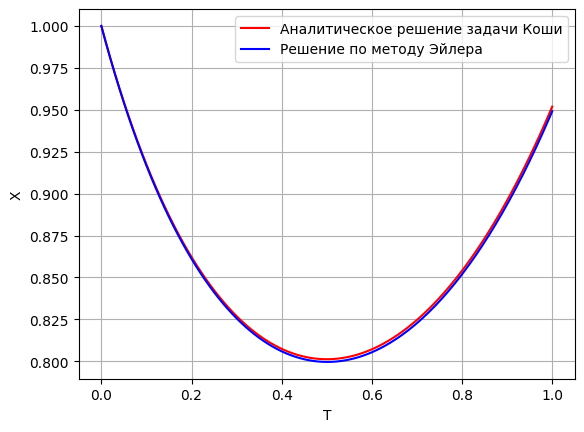

In [8]:
t_segment = [0, 1]
x_0 = [1]

start_time = time.perf_counter()
dt = 0.005
euler_t, euler_x = euler_method(f, t_segment, x_0, dt)
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", description="Решение по методу Эйлера")

Время работы метода: 0.0002730999840423465


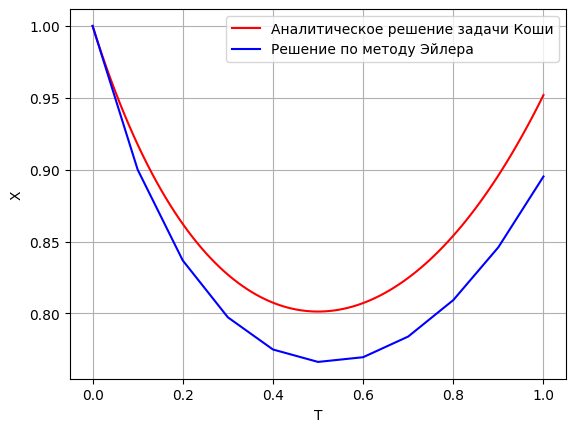

In [9]:
t_segment = [0, 1]
x_0 = [1]

start_time = time.perf_counter()
dt = 0.1
euler_t, euler_x = euler_method(f, t_segment, x_0, dt)
negative_euler_x = list(map(lambda el: -el, euler_x))
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")

Время работы метода: 0.00022530002752318978


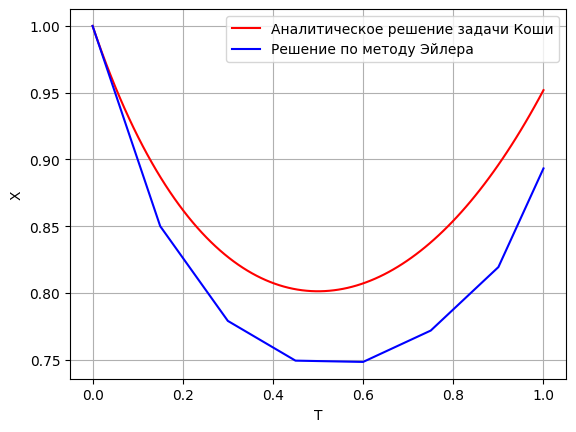

In [10]:
t_segment = [0, 1]
x_0 = [1]

start_time = time.perf_counter()
dt = 0.15
euler_t, euler_x = euler_method(f, t_segment, x_0, dt)
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")

### Сравнение ошибок для метода Рунге-Кутты с разными значениями шага ($\geqslant 3$)

Время работы метода: 0.0004780999734066427


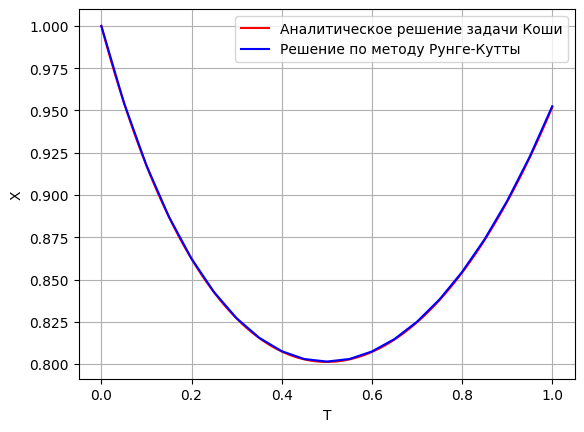

In [11]:
t_segment = [0, 1]
x_0 = [1]

start_time = time.perf_counter()
dt = 0.05
runge_kutta_t, runge_kutta_x = runge_kutta_method(f, t_segment, x_0, dt)
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(runge_kutta_t, runge_kutta_x, "blue", "Решение по методу Рунге-Кутты")

Время работы метода: 0.0003040999872609973


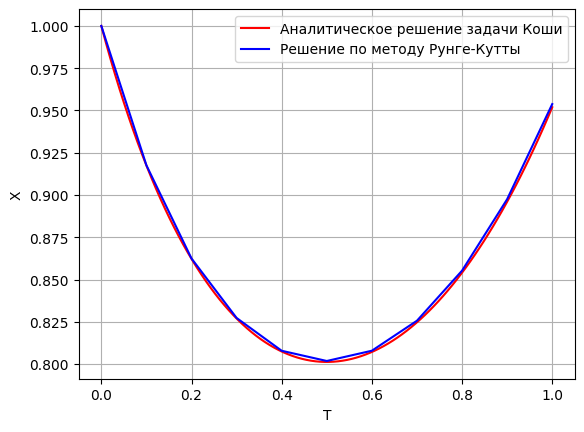

In [12]:
t_segment = [0, 1]
x_0 = [1]

start_time = time.perf_counter()
dt = 0.1
runge_kutta_t, runge_kutta_x = runge_kutta_method(f, t_segment, x_0, dt)
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(runge_kutta_t, runge_kutta_x, "blue", "Решение по методу Рунге-Кутты")

Время работы метода: 0.00029939995147287846


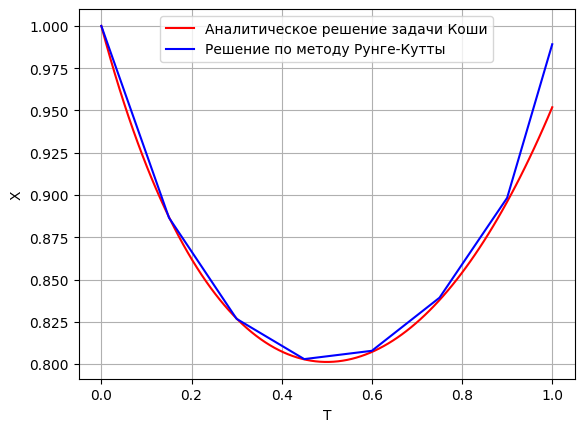

In [13]:
t_segment = [0, 1]
x_0 = [1]

start_time = time.perf_counter()
dt = 0.15
runge_kutta_t, runge_kutta_x = runge_kutta_method(f, t_segment, x_0, dt)
end_time = time.perf_counter()

print(f"Время работы метода: {end_time - start_time}")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(runge_kutta_t, runge_kutta_x, "blue", "Решение по методу Рунге-Кутты")

### Сравнение методов Эйлера и Рунге-Кутты между собой


Ошибка метода Эйлера: 0.05665498020531701
Ошибка метода Рунге-Кутты: 0.0018777810548321616


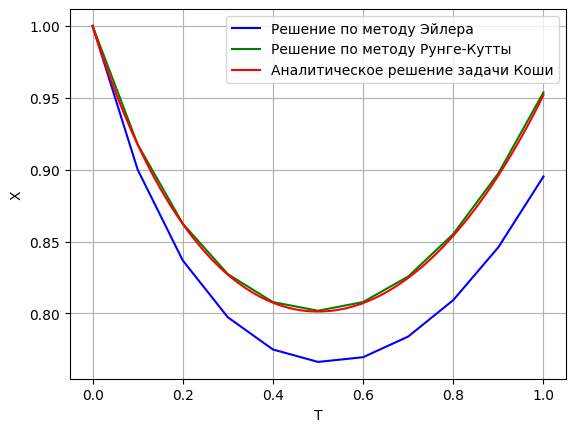

In [14]:
'''
Разница в ошибках при одинаковых шагах
'''

t_segment = [0, 1]
x_0 = [1]

dt = 0.1
runge_kutta_t, runge_kutta_x = runge_kutta_method(f, t_segment, x_0, dt)
euler_t, euler_x = euler_method(f, t_segment, x_0, dt)

print(f"\nОшибка метода Эйлера: {abs(phi(t_segment[-1]) - euler_x[-1][0])}"
      f"\nОшибка метода Рунге-Кутты: {abs(phi(t_segment[-1]) - runge_kutta_x[-1][0])}")

plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")
plot_arr(runge_kutta_t, runge_kutta_x, "green", "Решение по методу Рунге-Кутты")
plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")


Ошибка метода Эйлера: 0.0005524140247314957
Ошибка метода Рунге-Кутты: 0.0004660478232038079
Разница в шагах: 0.019844999999999998


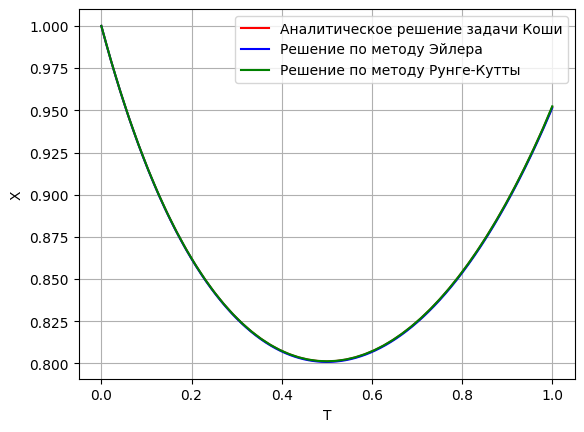

In [15]:
'''
Разница в шагах при (приблизительно) одинаковой ошибке
'''

t_segment = [0, 1]
x_0 = [1]

euler_dt = 0.001
runge_kutta_dt = 0.020845

runge_kutta_t, runge_kutta_x = runge_kutta_method(f, t_segment, x_0, runge_kutta_dt)
euler_t, euler_x = euler_method(f, t_segment, x_0, euler_dt)

print(f"\nОшибка метода Эйлера: {abs(phi(t_segment[-1]) - euler_x[-1][0])}"
      f"\nОшибка метода Рунге-Кутты: {abs(phi(t_segment[-1]) - runge_kutta_x[-1][0])}"
      f"\nРазница в шагах: {abs(euler_dt - runge_kutta_dt)}")

plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")
plot_arr(runge_kutta_t, runge_kutta_x, "green", "Решение по методу Рунге-Кутты")


Сделайте вывод относительно связи между размером шага, точностью и временем работы программы.

### Вывод
1. **Точность**: Метод Рунге-Кутты имеет значительно более высокую точность по сравнению с методом Эйлера при одинаковых значениях шага dt.

2. **Сравнение ошибок на одинаковых шагах**: При одинаковом шаге dt ошибка метода Эйлера значительно превышает ошибку метода Рунге-Кутты. Это указывает на то, что для достижения аналогичной точности метод Эйлера требует значительно более мелкого шага, что, в свою очередь, увеличивает количество шагов и вычислительную нагрузку.

3. **Эффективность вычислений**: Из-за второго порядка точности метод Рунге-Кутты позволяет использовать больший шаг при той же точности, что и метод Эйлера. Это делает его более эффективным для численного решения задач, так как он требует меньше вычислений для достижения заданной точности.

###### 2. Метод Эйлера справляется, но лишь сильное уменьшение шага дает адекватную точность. Метод Рунге-Кутты справляется хорошо

Придумайте пример дифференциального уравнения с некоторыми начальными условиями, для которого точности метода Эйлера может не хватить, а метод Рунге-Кутты выручает.  

Запустите написанные ранее методы для данной задачи и сравните численное решение с аналитическим (которое, правда, Вам снова придется найти честным способом на бумажке)

**Решить следующее дифференциальное уравнение:**
\begin{equation}
\begin{cases}
x^{\prime} + t^2 = 2x + 1 \\
x(0) = \frac{1}{2}.
\end{cases}
\end{equation}

**Решение**

1) Замена $x=u v, x^{\prime}=u^{\prime} v+u v^{\prime}$ Получаем:
$$
uv^{\prime} + vu^{\prime} - 2uv = 1 - t^2
$$

2) Далее необходимо вынести за скобку общий множитель и в первом и третьем слагаемом левой части дифференциального уравнения. Имеем:
$$
u^{\prime}v + u(v^{\prime} - 2v) = 1 - t^2
$$

3) Теперь каким-то образом нужно найти неизвестные функции $u$ и $v$. Чтобы их найти придётся составить систему уравнений:
$$
\begin{equation}
\begin{cases}
u(v^{\prime} - 2v) = 0, \\
u^{\prime}v = 1 - t^2.
\end{cases}
\end{equation}
$$

4) Заметим, что значение первого уравнения мы взяли равным нулю, чтобы из него получить $v$, а затем зная $v$ из второго получить $u$. Приступаем решать её:
$$
v^{\prime} - 2v = 0; 
$$
$$
v^{\prime} = 2v;
$$
$$
\frac{d v}{d t} = 2v;
$$
$$
\int \frac{dv}{v} = \int 2 dt;
$$
$$
\ln v = 2t;
$$
$$
v = e^{2t}
$$

5) Зная теперь чему равно $v$ возьмём и подставим его во второе уравнение системы. Далее найдём $u$:
$$
u^{\prime} \cdot e^{2t} = 1 - t^2;
$$
$$
\frac{d u}{d t} = \frac{1 - t^2}{e^{2t}};
$$
$$
u = -\int \frac{t^2 - 1}{e^{2t}} dt; 
$$
$$
u = - \int \frac{t^2}{e^{2t}} dt + \int e^{-2t} dt; 
$$
$$
u = - \frac{1}{2e^{2t}} - \int \frac{t^2}{e^{2t}} dt
$$
6) Решим $\int \frac{t^2}{e^{2t}} dt$. Сделаем замену $q = 2t \rightarrow t = \frac{q}{2}, dt = \frac{1}{2} dq$:
$$
\int \frac{t^2}{e^{2t}} d t = \int \frac{q^2}{8e^q} d q = \frac{1}{8} \int \frac{q^2}{e^q} d q;
$$
- Проинтегрируем по частям. $u = q^2 \rightarrow du = 2qdq, dv = \frac{1}{e^q}dq \rightarrow v = -\frac{1}{e^q}$. Получим:
$$
\frac{1}{8} \left( -\frac{q^2}{e^q} + \int \frac{2q}{e^q} dq \right)
$$
- Проинтегрируем интеграл по частям. $u = q \rightarrow du = dq$, $dv = \frac{1}{e^q}dq \rightarrow v = -\frac{1}{e^q}$. Получим:
$$
\frac{1}{8} \left( -\frac{q^2}{e^q} -\frac{2q}{e^q} + 2\int \frac{1}{e^q} dq \right) = \frac{1}{8} \left( -\frac{q^2}{e^q} -\frac{2q}{e^q} - \frac{2}{e^q} \right)
$$
- Обратной подстановкой получим интеграл:
$$
-\frac{2t^2 + 2t + 1}{4e^{2t}} + C
$$
- Теперь мы можем получить $u$:
$$
u = - \frac{1}{2e^{2t}} + \frac{2t^2 + 2t + 1}{4e^{2t}} + C = \frac{2t^2 + 2t - 1}{4e^{2t}} + C
$$

7) Теперь с помощью обратной подстановки мы можем получить $x = uv$:
$$
x = e^{2t} \cdot \left(\frac{2t^2 + 2t - 1}{4e^{2t}} + C \right) = Ce^{2t} + \frac{t^2}{2} + \frac{t}{2} - \frac{1}{4}
$$

8) Решим задачу Коши:
$$
\frac{1}{2} = Ce^{0} + \frac{0^2}{2} + \frac{0}{2} - \frac{1}{4} \Rightarrow C = \frac{3}{4}
$$

In [16]:
'''
Задайте функцию f(t,x) — правую часть предложенного уравнения
'''

def f(t,x):
    return 2 * x - t ** 2 + 1

In [17]:
'''
Задайте функцию phi(t) — аналитическое решение задачи Коши
'''

def phi(t):
    return (3 / 4) * np.exp(2 * t) + (t ** 2 / 2) + (t / 2) - (1 / 4)

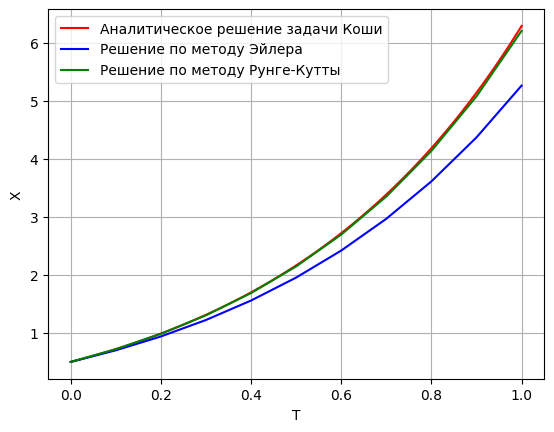

In [18]:
'''
Постройте необходимые графики для анализа
(не забудьте добавить легенду к графикам, чтобы отличать решения)
'''

t_segment = [0, 1]
x_0 = [0.5]

dt = 0.1
runge_kutta_t, runge_kutta_x = runge_kutta_method(f, t_segment, x_0, dt)
euler_t, euler_x = euler_method(f, t_segment, x_0, dt)

plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")
plot_arr(runge_kutta_t, runge_kutta_x, "green", "Решение по методу Рунге-Кутты")


Сделайте вывод относительно причин, по которым получается такое поведение методов.

Это уравнение содержит экспоненциальный компонент и квадратичную зависимость по $t$, что усложняет точное вычисление методом Эйлера при больших шагах, так как ошибки будут накапливаться. Однако метод Рунге-Кутты второго порядка, учитывая промежуточное значение (среднее), даёт более точные результаты даже при относительно большом шаге.

###### 3. Оба этих метода не справляются с задачей

Придумайте пример дифференциального уравнения с некоторыми начальными условиями, для которого ни метод Эйлера, ни метод Рунге-Кутты не может получить хорошего результата.  

Запустите написанные ранее методы для данной задачи и сравните численное решение с аналитическим (которое, правда, Вам снова придется найти честным способом на бумажке)

**Решить следующее дифференциальное уравнение:**
\begin{equation}
\begin{cases}
x^{\prime} = 5e^{ 0.5t}\sin3t-10x \\
x(0) = 1.
\end{cases}
\end{equation}

**Решение:**

$$
dx = \left(5 e^{ 0.5t} \sin 3t - 10 x\right) dt
$$

1) Переносим слагаемое на другую сторону:
$$
dx + \left(10 x - 5 e^{ 0.5t} \sin 3t\right) dt = 0
$$

2) Найдем интегрирующий множитель для уравнения:
$$
M(t, x) \, dx + N(t, x) \, dt = 0;
$$
$$
M(t, x) = 1 \quad \text{и} \quad N(t, x) = 10 x - 5 e^{ 0.5t} \sin 3t
$$

3) Проверим на полный дифференциал:
$$
\frac{\partial M}{\partial t} = 0 \neq \frac{\partial N}{\partial x} = 10
$$

4) Для приведения уравнения к уравнению в полных дифференциалах найдем интегрирующий множитель $\mu (t)$.
$$
\frac{\partial (\mu M)}{\partial t} = \frac{\partial (\mu N)}{\partial x};
$$
$$
M \cdot \frac{\partial \mu}{\partial t} - N \cdot \frac{\partial \mu}{\partial x} = \mu \left(\frac{\partial N}{\partial x} - \frac{\partial M}{\partial t} \right);
$$
$$
\mu(t, x) = \mu(t) \Rightarrow \frac{\partial \mu}{\partial x} = 0;
$$
$$
\frac{1}{\mu}\frac{d \mu}{d t} = \frac{1}{M} \left( \frac{\partial N}{\partial x} - \frac{\partial M}{\partial t} \right);
$$
$$
\int \frac{d\mu}{\mu} = \int \frac{1}{M} \left ( \frac{\partial N}{\partial x} - \frac{\partial M}{\partial t} \right) dt = \int 10 dt = 10t \Rightarrow \ln \mu = 10t \Rightarrow \mu = e^{10t}
$$

5) Умножаем обе стороны на $e^{10t}$:
$$
e^{10t} \, dx + \left(10 e^{ 10t} x - 5 e^{10.5t} \sin 3t\right) dt = 0
$$

6) Уравнение в полных дифференциалах:
$$
M(t, x) \, dx + N(t, x) \, dt = 0;
$$
$$
M(t, x) = e^{ 10t}, \quad N(t, x) = 10 x e^{ 10t} - 5 e^{10.5t} \sin 3t;
$$
$$
\frac{\partial M}{\partial t} = \frac{\partial N}{\partial x} = 10e^{ 10t}
$$

7) Найдем функцию $F(t, x)$, такую, чтобы выполнялось:
$$
dF(t, x) = M(t, x) \, dx + N(t, x) \, dt;
$$
$$
\frac{\partial F}{\partial x} = M(t, x), \quad \frac{\partial F}{\partial t} = N(t, x)
$$

8) Интегрируем последнее уравнение по $t$:
$$
F(t, x) = \int N(t, x) \, dt;
$$
$$
\int \left( 10e^{ 10 t}x - 5e^{ 10.5t}\sin3t \right ) dt= \int 10e^{ 10 t}x dt - \int 5e^{ 10.5t}\sin3t dt =  -\frac{70e^{ 10.5t}\sin3t}{159} + \frac{20e^{ 10.5t}\cos3t}{159} + e^{ 10t}x + C_x
$$

9) Вычисляем производную:
$$
M(t, x) = \frac{\partial F}{\partial x} = e^{ 10t} + C^{\prime}_x
$$

10) Интегрируем последнее уравнение по $x$:
$$
C_x = \int \left(M(t, x) - e^{10t}\right)dx = \int 0 dx = 0
$$

11) Искомая функция: 
$$
F(t, x) = -\frac{70e^{ 10.5t}\sin3t}{159} + \frac{20e^{ 10.5t}\cos3t}{159} + e^{ 10t}x = C;
$$
$$
x = \frac{70e^{ 0.5t}\sin3t}{159} - \frac{20e^{ 0.5t}\cos3t}{159} + \frac{C}{e^{ 10t}}
$$

12) Задача Коши:

$$
1 = C - \frac{20}{159} \rightarrow C = \frac{179}{159} 
$$

❗ **Место для Вашего решения** ❗

In [19]:
'''
Задайте функцию f(t,x) — правую часть предложенного уравнения
'''

def f(t,x):
    return 5 * np.exp(0.5 * t) * np.sin(3 * t) - 10 * x


In [20]:
'''
Задайте функцию phi(t) — аналитическое решение задачи Коши
'''

def phi(t):
    return (70 / 159) * np.exp(0.5 * t) * np.sin(3 * t) - (20 / 159) * np.exp(0.5*t)*np.cos(3 * t) + (179 /(159 * np.exp(10 * t)))


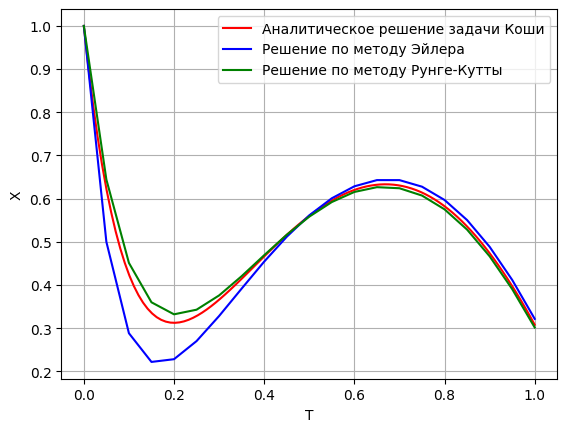

In [21]:
'''
Постройте необходимые графики для анализа
(не забудьте добавить легенду к графикам, чтобы отличать решения)
'''

t_segment = [0, 1]
x_0 = [1]

dt = 0.05
runge_kutta_t, runge_kutta_x = runge_kutta_method(f, t_segment, x_0, dt)
euler_t, euler_x = euler_method(f, t_segment, x_0, dt)


plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")
plot_arr(runge_kutta_t, runge_kutta_x, "green", "Решение по методу Рунге-Кутты")


Сделайте вывод относительно причин неприменимости этих методов.

Методы Эйлера и Рунге-Кутты второго порядка плохо справляются с этим уравнением, потому что решение «жесткое»: экспонента быстро увеличивает амплитуду колебаний синуса. Чтобы следить за таким быстрым ростом и частыми колебаниями, нужен очень маленький шаг, иначе численное решение быстро уходит в сторону.

###### 4. Применимость методов для задачи с особым решением

Придумайте пример дифференциального уравнения с некоторыми начальными условиями, для которого существует особое решение.  

Запустите написанные ранее методы для данной задачи и сравните численное решение с аналитическим (которое, правда, Вам снова придется найти честным способом на бумажке)

**Решить следующее дифференциальное уравнение:**
\begin{equation}
\begin{cases}
2x(x^{\prime} + 2) - t(x^{\prime})^2 = 0 \\
x(0) = 1
\end{cases}
\end{equation}

**Решение:**

1) Это уравнение, не разрешенное относительно производной. Введем параметр:
$$
p = x^{\prime} \rightarrow d t = \frac{d x}{p}
$$
2) Получим:
$$
2x(p + 2) - tp^2 = 0 \Rightarrow t = \frac{2x}{p} + \frac{4x}{p^2}
$$
3) Возьмем полный дифференциал от обеих частей уравнения:
$$
dt = \frac{2pdx - 2xdp}{p^2} + \frac{4p^2dx - 8 p x dp}{p^4} = \frac{2pdx - 2xdp}{p^2} + \frac{4pdx - 8xdp}{p^3} = \frac{2p^2dx + 4pdx - 2p x dp - 8xdp}{p^3}
$$
4) Сделаем обратную замену и получим:
$$
dx = \frac{2p^2dx + 4pdx - 2p x dp - 8xdp}{p^2};
$$
$$
\left (-\frac{4}{p} - 1 \right) dx = \left (-\frac{2x}{p} - \frac{8x}{p^2} \right) dp;
$$
$$
\left (-\frac{4}{p} - 1 \right) dx = \left (- \frac{4}{p} - 1 \right) \frac{2xdp}{p} \Rightarrow \frac{dx}{x} = 2\frac{dp}{p}
$$
5) Мы получаем в итоге уравнение с разделяющими переменными:
$$
\int \frac{dx}{x} = \int 2\frac{dp}{p} \Rightarrow \ln x = 2ln p + C \Rightarrow x = C \cdot p^2
$$
6) Выразим параметр:
$$
p = \pm \sqrt{\frac{x}{C}}
$$
7) Подставим $p$ в $t = \frac{2x}{p} + \frac{4x}{p^2}$. Тогда получим:
$$
t = \pm 2 \sqrt{C} \sqrt{x} + 4C;
$$
$$
x = \frac{(C - t)^2}{C}
$$
8) Решим задачу Коши:
$$
\frac{C^2}{C} = 1 \Rightarrow C = 1
$$

❗ **Место для Вашего решения** ❗

In [22]:
'''
Задайте функцию f(t,x) — правую часть предложенного уравнения
'''

def f(t, x):
    discriminant = 4*x ** 2 + 16 * x * t
    if discriminant < 0:
        return np.nan
    
    return (2 * x + np.sqrt(discriminant)) / (2 * t) if t != 0 else 0

In [23]:
'''
Задайте функцию phi(t) — аналитическое решение задачи Коши
'''

def phi(t):
    return (1 - t) ** 2

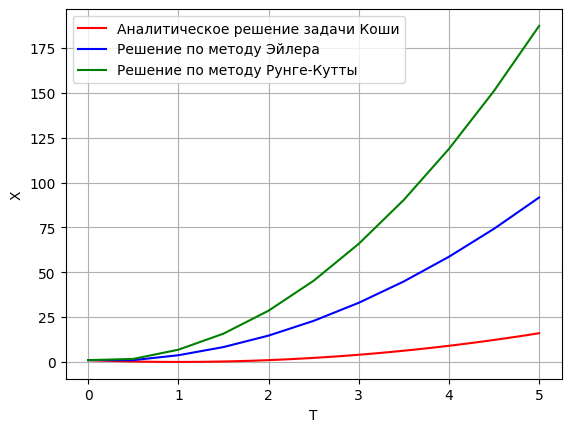

In [24]:
'''
Постройте необходимые графики для анализа
(не забудьте добавить легенду к графикам, чтобы отличать решения)
'''

t_segment = [0, 5]
x_0 = [1]

dt = 0.5
runge_kutta_t, runge_kutta_x = runge_kutta_method(f, t_segment, x_0, dt)
euler_t, euler_x = euler_method(f, t_segment, x_0, dt)


plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(euler_t, euler_x, "blue", "Решение по методу Эйлера")
plot_arr(runge_kutta_t, runge_kutta_x, "green", "Решение по методу Рунге-Кутты")


Сделайте вывод относительно произошедшего в моделировании и применимости этих методов к задачам с особым решением.

На основе графика можно сделать вывод, что методы Эйлера и Рунге-Кутты второго порядка демонстрируют значительные расхождения с аналитическим решением, особенно метод Рунге-Кутты, который неожиданно дает большее отклонение. Это связано с присутствием особых решений, таких как $x = 0$ и $x = -4t$, которые создают асимптотическое поведение в решении. Такие особенности делают данные методы менее подходящими для задач с особыми решениями, поскольку они не обеспечивают необходимой точности и устойчивости.

#### \* Дополнительное размышление (Дополнительное задание _по желанию_)

Посмотрите, какие методы могут использоваться для исправления выявленных недостатков приведенных выше методов.

- Опишите кратко теоретические выкладки относительно одного из таких методов.
- Попробуйте объяснить, каким образом предложенный метод помогает бороться с различными недостатками.
- Опишите проблемы, которые появляются (или также проявляются) по сравнению с стандартными методами (Эйлера и Рунге-Кутты).
- Приведите пример, в котором методы Эйлера и Рунге-Кутты не решают задачу, а предложенный в этом пункте метод справляется.

## Метод Рунге-Кутты 4-го порядка: Теоретические выкладки

### Формулировка
Метод Рунге-Кутты 4-го порядка является одним из наиболее популярных численных методов для решения обыкновенных дифференциальных уравнений (ОДУ). Он обеспечивает баланс между точностью и вычислительной сложностью, сохраняя глобальную ошибку порядка $O(h^4)$.

Для ОДУ:
$$
\frac{dx}{dt} = f(t, x), \quad x(0) = x_0,
$$
метод Рунге-Кутты 4-го порядка вычисляет $x_{n+1}$ по следующей формуле:
$$
x_{n+1} = x_n + \frac{h}{6} (k_1 + 2k_2 + 2k_3 + k_4),
$$
где:
$$
\begin{aligned}
  k_1 &= f(t_n, x_n), \\
  k_2 &= f\left(t_n + \frac{h}{2}, x_n + \frac{h}{2} k_1\right), \\
  k_3 &= f\left(t_n + \frac{h}{2}, x_n + \frac{h}{2} k_2\right), \\
  k_4 &= f(t_n + h, x_n + h k_3).
\end{aligned}
$$

### Особенности метода
1. **Порядок точности**: Метод Рунге-Кутты 4-го порядка имеет локальную ошибку $O(h^5)$ и глобальную ошибку $O(h^4)$, что делает его значительно точнее, чем методы Эйлера или Рунге-Кутты второго порядка.
2. **Явная схема**: Метод не требует решения нелинейных уравнений на каждом шаге, что снижает вычислительную сложность по сравнению с неявными методами.
3. **Универсальность**: Метод подходит для широкого класса задач, включая жёсткие системы (при небольшом шаге $h$).

### Преимущества метода Рунге-Кутты 4-го порядка
- Высокая точность при относительно больших шагах интегрирования.
- Простота реализации и отсутствие необходимости решать нелинейные системы.
- Широкое применение для моделирования физических, биологических и инженерных систем.

### Недостатки
- **Неустойчивость на жёстких задачах**: Метод Рунге-Кутты 4-го порядка становится неустойчивым при больших шагах на жёстких задачах.
- **Вычислительная стоимость**: Требуется 4 вызова функции $f$ на каждом шаге, что может быть ресурсозатратно при сложных системах или высокоразмерных задачах.

**Метод Метод Рунге-Кутты 4-го порядка** обеспечивает точное решение этой задачи при разумных значениях шага $h$, в то время как методы более низкого порядка требуют значительно меньшего шага для аналогичной точности. Давайте убедимся в этом и вернемся к 3 задаче.


### Реализация метода Рунге-Кутты 4 порядка:

In [25]:
def runge_kutta_method_of_the_fourth_order(fun, t, x_0, dt, args={}):
    t_points = np.clip(np.arange(t[0], t[1] + dt, dt), t[0], t[1])
    
    x_points = np.zeros((len(t_points), len(x_0)))
    x_points[0] = x_0

    x_current = np.asarray(x_0)
    
    for i in range(1, len(t_points)):
        t_current = t_points[i-1]
        
        k1 = fun(t_current, x_current, **args)
        k2 = fun(t_current + dt / 2, x_current + dt / 2 * k1, **args)
        k3 = fun(t_current + dt / 2, x_current + dt / 2 * k2, **args)
        k4 = fun(t_current + dt, x_current + dt * k3, **args)
        
        x_next = x_current + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        x_points[i] = x_next
        
        x_current = x_next
    
    return t_points, x_points

### Пример:

In [26]:
'''
Задайте функцию f(t,x) — правую часть предложенного уравнения
'''

def f(t, x):    
    return 5 * np.exp(0.5 * t) * np.sin(3 * t) - 10 * x

In [27]:
'''
Задайте функцию phi(t) — аналитическое решение задачи Коши
'''

def phi(t):
    return (70 / 159) * np.exp(0.5 * t) * np.sin(3 * t) - (20 / 159) * np.exp(0.5*t)*np.cos(3 * t) + (179 /(159 * np.exp(10 * t)))

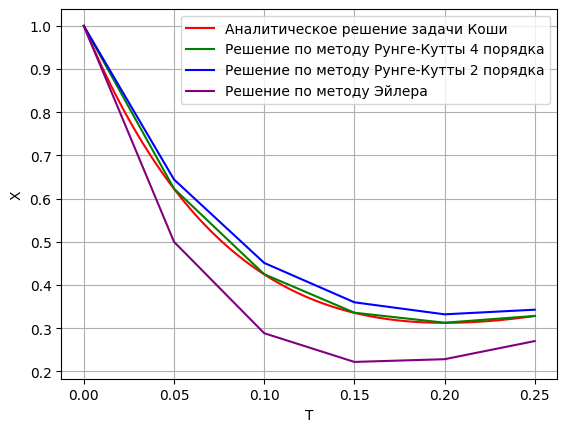

In [28]:
'''
Постройте необходимые графики для анализа
(не забудьте добавить легенду к графикам, чтобы отличать решения)
'''

t_segment = [0, 0.25]
x_0 = [1]

dt = 0.05
runge_kutta_4_t, runge_kutta_4_x = runge_kutta_method_of_the_fourth_order(f, t_segment, x_0, dt)
runge_kutta_t, runge_kutta_x = runge_kutta_method(f, t_segment, x_0, dt)
euler_t, euler_x = euler_method(f, t_segment, x_0, dt)


plot_func(t_segment, phi, "red", "Aналитическое решение задачи Коши")
plot_arr(runge_kutta_4_t, runge_kutta_4_x, "green", "Решение по методу Рунге-Кутты 4 порядка")
plot_arr(runge_kutta_t, runge_kutta_x, "blue", "Решение по методу Рунге-Кутты 2 порядка")
plot_arr(euler_t, euler_x, "purple", "Решение по методу Эйлера")

## Задание 2. Восстановление цифр по бракованным картинкам.

В этом пункте мы посмотрим на неожи

### Описание задачи

Вам предоставлен кусок тренировочной выборки из базы данных [MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset). А также бракованные изображения из этого же датасета.

<p>    
    <center>
    <img src="https://drive.google.com/uc?export=view&id=1jgWvIHwXkhQ1iE6ER0Wy_SLxBvCWW1Dd" alt="Проблемы с отображением изображения. Обратитесь к автору" width=500>
    <img src="https://drive.google.com/uc?export=view&id=1AET7slaGnEePLx3qjrxycJSXfHJg55bz" alt="Проблемы с отображением изображения. Обратитесь к автору" width=500>
    <em><br>Пример данных из датасета MNIST<br>Сначала: тренировочные изображения,<br>Потом: бракованные изображения</em>
    </center>
</p>

Необходимо, используя простейшую версию [нейронной сети Хопфилда](https://arxiv.org/abs/2008.02217), восстановить цифры на бракованных изображениях.

<p>    
    <center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/b/b4/Hopfield%27s_net.png" alt>
    <em><br>Пример: схема нейронной сети Хопфилда с тремя нейронами</em>
    </center>
</p>

Переписывая заданную в нейронной сети Хопфилда структуру с $m$ нейронами в виде уравнения в матричном виде, можно получить
$$\boxed{x' = A^T \mathrm{softmax}(\beta Ax) - x}, \tag{1}$$
где $A$ — $\text{матрица}_{(m \times n)}$ весов, $\beta \in \mathbb{R}$, $x$ — $\text{вектор}_{(n, 1)}$ входных нейронов, $\mathrm{softmax}(z)_i = \frac{e^{z_i}}{\sum_{k} e^{z_k}}$ — функция активации.

А значит, задача применения нейронной сети с известной$^*$ матрицей весов сводится к решению дифференциального уравнения (1).

<sub>$^*$ Матрица с весами нетрудно получается на
основе тренировочных данных, о чем мы поговорим чуть дальше.</sub>

Нам дальше понадобится функция $\mathrm{softmax}(x)$. Реализуйте более удобную далее в применении $\mathrm{softmax}(\beta \cdot x)$ в функции `softmax(x, beta)`, рассматривая $x$ как массив `numpy.array`, а $\beta$ — как число.

In [29]:
'''
Функция softmax(beta*x)
x — numpy.array
beta — число
'''

def softmax(x, beta=1):
    e_x = np.exp(beta * (x - np.max(x)))
    return e_x / e_x.sum(axis=0)

Запишите правую часть уравнения (1), с которым мы дальше будем активно работать, в функцию `dynamics(x, A, beta)`. Используйте в качестве $x$ и $A$ массивы `numpy.array`, а в качестве $\beta$ — число.

In [30]:
'''
Правая часть уравнения (1)
x — numpy.array
A — numpy.array
beta — число
'''

def dynamics(t, x, A, beta):
    return  np.dot(A.T, softmax(beta * np.dot(A, x))) - x

### Интуитивное понимание принципа работы нейронной сети Хопфилда


#### Простой случай на плоскости

Для того, чтобы понять, почему предложенный выше метод работает, необходимо углубиться в дифференциальное уравнение (1).

Как мы помним, для начального анализа мы можем использовать некоторые графические методы. Например, изоклины, или, в более общем случае, --- векторные поля.

Постройте с помощью [`plt.quiver`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html) векторное поле для уравнения $x' = A^T \mathrm{softmax} (\beta A x)-x$, положив $A = \begin{bmatrix}1&0\\0&1\\-1&-1\end{bmatrix}$, $\beta=5$.

Добавьте на этот же график точки* $(1,0), (0,1), (-1,-1)$.

_* Заметьте, что это просто точки из матрицы $A$, координаты которых находятся в строках этой матрицы_.

In [31]:
'''
Реализуем функцию для построения векторного поля уравнения x' = A^T softmax(beta * A * x) - x и построения точек матрицы A
'''

def plot_vector_field(A, beta):
    x_vals = np.linspace(-7, 7, 30)
    y_vals = np.linspace(-7, 7, 30)
    X, Y = np.meshgrid(x_vals, y_vals)

    U = np.zeros(X.shape)
    V = np.zeros(Y.shape)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = np.array([X[i, j], Y[i, j]])
            vec = dynamics(None, x, A, beta)
            U[i, j] = vec[0]
            V[i, j] = vec[1]

    plt.figure(figsize=(10, 10))
    plt.quiver(X, Y, U, V, color='blue', alpha=0.6, scale=40)

    points = A
    plt.scatter(points[:, 0], points[:, 1], color='red', s=120, label='Точки матрицы A')

    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title("Векторное поле")
    plt.grid()
    plt.show()

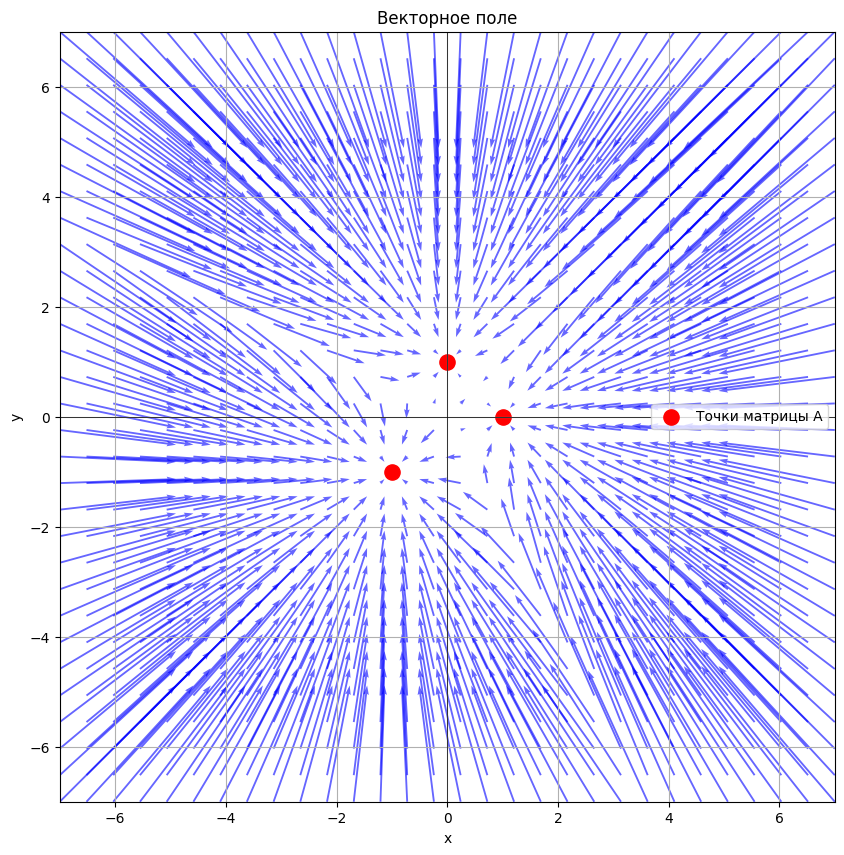

In [32]:
'''
Векторное поле уравнения x' = A^T softmax(beta * A * x) - x
A = [[1, 0], [0, 1], [-1, -1]]
beta = 5
'''
plot_vector_field(np.array([[1, 0], [0, 1], [-1, -1]]), 5)

Замечаете странное поведение стрелочек? Они как будто смотрят на одну из наших выбранных точек.

Давайте проверим, сохранится ли такое поведение при другой матрице $A$.

Рассмотрите матрицу $A=\begin{bmatrix}2&2\\2&-1\\-3&4\\-4&-3\end{bmatrix}$.

Постройте векторное поле и найдите, какие точки обладают таким же поведением (к ним тянутся стрелочки).


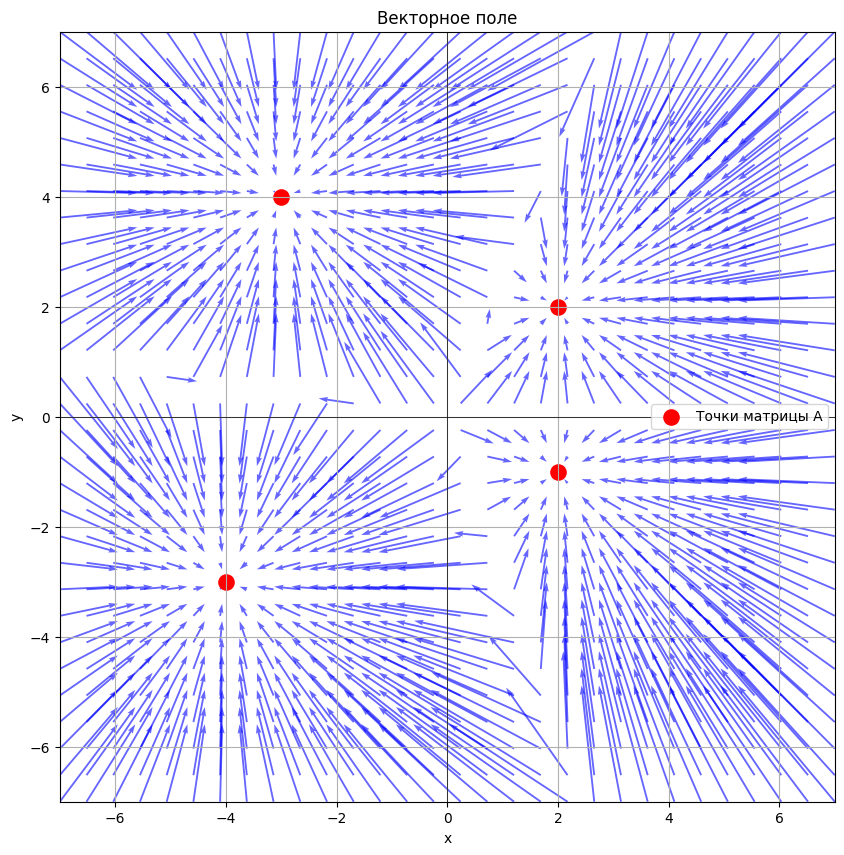

In [33]:
'''
Векторное поле уравнения x' = A^T softmax(beta * A * x) - x
A = [[2,2],[2,-1],[-3,4],[-4,-3]]
beta = 5
'''
plot_vector_field(np.array([[2,2],[2,-1],[-3,4],[-4,-3]]), 5)

Не кажется ли это очень неплохим свойством? Вспомним, что векторное поле показывает как будто бы «направление скорости» нашей системы. А значит, начиная из какой-нибудь точки на плоскости, мы «скатимся» по стрелочкам в одну из заданных нами в матрице $A$ точек.

Подробнее о таком поведении мы поговорим ближе к концу семестра в курсе, а пока стоит понимать это именно на таком интуитивном уровне.


На самом деле, наша система (1) дает даже больше.

Давайте рассмотрим матрицу $A=\begin{bmatrix}2&3\\-3&2\\2&5\\-2&-3\\3&5\end{bmatrix}$. Видно, что несколько предполагаемых "точек притяжения" сгруппированы в первой четверти плоскости.

Постройте векторное поле для уравнения (1), используя данную матрицу, и посмотрите, как наше уравнение справляется с такими сгруппированными точками.

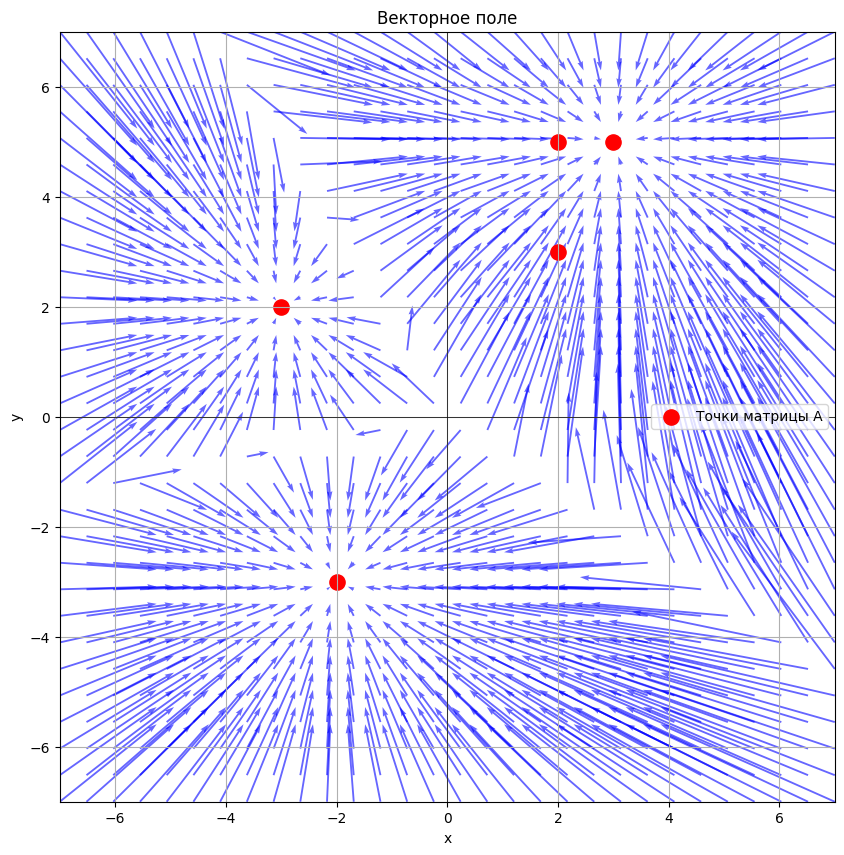

In [34]:
'''
Векторное поле уравнения x' = A^T softmax(beta * A * x) - x
A = [[2,3],[-3,2],[2,5], [-2,-3],[3,5]]
beta = 5
'''
plot_vector_field(np.array([[2,3],[-3,2],[2,5], [-2,-3],[3,5]]), 5)

Замечательно! Оказывается, что среди этих сгруппированных точек выделяется одна, которая «притягивает сильнее».



Возможно, Вам до сих пор не очень понятно, к чему все эти рассуждения и как они помогут нам с обработкой изображения. Давайте переложим рассмотренные выше идеи на датасет `MNIST`.

#### Отношение к изображениям и цифрам

Вспомним, что картинка в компьютере представляется массивом размера `(height, width)`.

Теперь представьте, что мы рассматриваем распрямленную$^*$ картинку, то есть каждый пиксель записан на новой строчке. Получившийся вектор имеет размер `(width*height,1)`.

И этот вектор мы можем подставлять в наше уравнение (1). Решая это уравнение, получим какой-то вектор новой распрямленной картинки, который мы можем обратно привести к исходному размеру `(height, width)`.

<sub>* Заметьте, что мы не теряем информацию о картинке, если помним изначальные размеры, так как в любой момент можем обратно собрать изображение по распрямленному.</sub>

Остается лишь вопрос в матрице $A$. Какую ее брать?

И оказывается, что тут нам помогут наши «точки притяжения». Ведь если мы знаем на каком-то тренировочном наборе, как примерно выглядят цифры, то можем их положить в матрицу $A$. Таким образом, мы получим, что наши тренировочные картинки являются «точками притяжения» для бракованных. А значит любая бракованная, следуя по стрелочкам векторного поля$^*$, придет к одной из тренировочных картинок, тем самым восстановив цифру на изображении.

То есть матрица $A$ будет выглядеть примерно
$$
A =
\begin{bmatrix}
    \text{тренировочная распрямленная картинка 1}\\
    \text{тренировочная распрямленная картинка 2}\\
    \vdots\\
    \text{тренировочная распрямленная картинка k}\\
\end{bmatrix}.
$$

<sub>* Стоит помнить, что теперь мы все манипуляции проворачиваем в пространстве размерности `width*height`. И там уже, конечно, под векторным полем понимается немного другое и изобразить это практически невозможно.</sub>

### Основная часть

#### Загрузка данных

<table>
  <tr>
    <td style="width:40%"><img src=https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.HVapjsP3IhY1D-JsrfGN9gHaEo%26pid%3DApi&f=1&ipt=98ac0d905405b055fade0f342067785a1f2a3e3c9dab7a80c787fcb5627cd771&ipo=images width=200></td>
    <td style="width:50%"><center><p>Выборка из датасета производится случайным образом!<br>
    Если Вы хотите работать с одними и теми же данными,<br>то сохраните файл <code>mnist.npz</code> к себе на компьютер <br>и каждый раз добавляйте его в Colab,<br>пользуясь кодом ниже.<br> Тогда данные будут читаться из него.</center></p></td>
  </tr>
</table>

Training Images


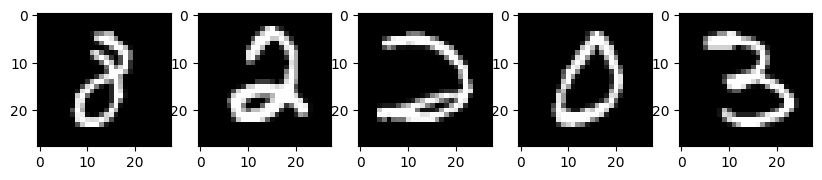

Corrupted Images


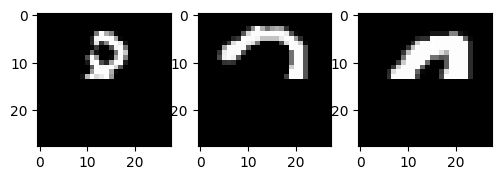

In [35]:
# @title Загрузка выборки из датасета (запустите ячейку, исходный код скрыт) { vertical-output: true, form-width: "100%", display-mode: "form" }

import os
import torchvision.datasets as datasets
from random import sample

def show_images(images):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,10))
    plt.tight_layout()
    index = 1
    for x in images:
        image = x
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        index += 1

if not os.path.exists('/content/mnist.npz'):
    mnist_trainset = datasets.MNIST(root='/content/MNIST', train=True, download=True)
    train = [np.array(mnist_trainset[k][0]) for k in sample(range(len(mnist_trainset)), 5)]
    test = [np.array(mnist_trainset[k][0]) for k in sample(range(len(mnist_trainset)), 3)]
    np.savez('/content/mnist.npz', train=train, test=test)

data = np.load("/content/mnist.npz")
training_img = data["train"]
training_img = np.asarray(training_img)
corrupted_img = data["test"]
corrupted_img_true = data['test']
for i, item in enumerate(corrupted_img):
    corrupted_img[i][14:, :] = 0

print("Training Images")
show_images(training_img)
plt.show()

print("Corrupted Images")
show_images(corrupted_img)
plt.show()

Теперь у нас есть два набора:
- `training_img` — массив с изображениями, представленными в виде массивов $(28\times 28)$,
- `corrupted_img` — массив с бракованными изображениями, представленными в виде массивов $(28\times 28)$.

#### Обработка данных

Как мы выяснили ранее, для работы с изображениями нам необходимо их распрямить, то есть привести к вектору размера $(784 \times 1)$.

Запишите в переменные `training_img_flatten` и `corrupted_img_flatten` массивы распрямленных изображений соответствующих наборов `training_img` и  `corrupted_img`. Выведите получившиеся размеры массивов, используя [`numpy.shape`](https://numpy.org/doc/stable/reference/generated/numpy.shape.html).

<sub>_Указание:_ воспользуйтесь функцией [`numpy.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)</sub>

In [36]:
'''
Распрямите изображения и запишите итоговые массивы в переменные training_img_flatten, corrupted_img_flatten.
'''
training_img_flatten = training_img.reshape(training_img.shape[0], -1)
corrupted_img_flatten = corrupted_img.reshape(corrupted_img.shape[0], -1)

print("Размер массива training_img_flatten:", np.shape(training_img_flatten))
print("Размер массива corrupted_img_flatten:", np.shape(corrupted_img_flatten))

Размер массива training_img_flatten: (5, 784)
Размер массива corrupted_img_flatten: (3, 784)


#### Обучение сети

Основываясь на наших предположениях из интуитивного понимания принципа работы, заполните матрицу $A$. В этом и заключается обучение нашей сети.

In [37]:
'''
Задайте матрицу весов A
'''
A = training_img_flatten
print("Размер массива training_img_flatten:", np.shape(A))

Размер массива training_img_flatten: (5, 784)


$\beta$ зададим равной $10^{-5}$. Вы можете поизменять этот гиперпараметр и написать в выводе, что меняется, или почитать в открытых источниках.

In [38]:
beta = 1e-5

#### Применение обученной сети = решение дифференциального уравнения

Получается, что применение нашей сети сводится к решению задачи Коши с уравнением (1) и начальным условием, равным бракованной картинке, которую мы хотим восстановить. Понятно, что решать ее в явном виде не имеет смысла (по-крайней мере, потому что это система из 784 уравнений с функцией $\mathrm{softmax}$ внутри). Поэтому будем решать численно.

Воспользуйтесь функцией `euler_method` из первого задания для решения заданной задачи Коши для каждой бракованной картинки с подставленными матрицей $A$ и скаляром $\beta$.

Получившиеся решения запишите в переменные `solution_i`, где $i$ — порядковый номер бракованной картинки (начинается с нуля).

In [39]:
'''
Запишите решения задач Коши в переменные solution_i
'''

solutions = []
t_segment = (0, 5)
dt = 0.001


for i, corrupted_image in enumerate(corrupted_img_flatten):
    t_points, solution = euler_method(
        dynamics,
        t_segment,
        corrupted_image,
        dt,
        args={'A': A, 'beta': beta}
    )
    solutions.append(
        solution[-1].reshape(28, 28) # 1x728 -> 28x28
    )


Выведите получившиеся восстановленные изображения бок о бок с исходными бракованными. Как Вы думаете, угадал ли компьютер с цифрой? Сделайте вывод почему.

Corrupted images


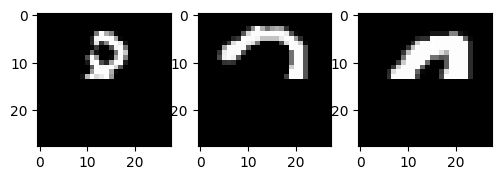

Restored images


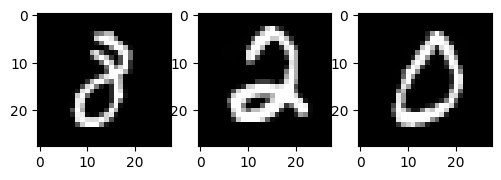

In [40]:
'''
Вывод изображений: бракованное | восстановленное
'''
print("Corrupted images")
show_images(corrupted_img)
plt.show()

print("Restored images")
show_images(solutions)
plt.show()

#### Вывод

Сделайте выводы относительно того, насколько удачно сработала нейронная сеть. Порассуждайте, почему так произошло.


**Выводы по результатам работы сети Хопфилда**

Сеть Хопфилда продемонстрировала способность частично восстанавливать искаженные изображения. Восстановление было успешным в тех случаях, когда искажения были минимальны, что позволило сети корректно воспроизвести исходные шаблоны. Однако при сильных искажениях качество восстановления снижалось, и сеть не всегда возвращала изображение, близкое к оригиналу. Это связано с тем, что сеть Хопфилда работает как система памяти с ограниченной емкостью, и при сильных искажениях начальные условия могли оказаться вне области притяжения нужного состояния, что приводило к некорректным результатам. Коэффициент `beta` в модели определяет "резкость" функции `softmax`, влияя на то, насколько сильно сеть различает состояния. При больших значениях функция `softmax` становится более чувствительной к различиям в весах, что может улучшить точность восстановления. Однако слишком высокие значения `beta`  могут привести к нестабильности сети и возникновению резких переходов между состояниями, снижая ее устойчивость. Оптимальное значение `beta` помогает сети точнее различать и восстанавливать искаженные шаблоны, обеспечивая баланс между точностью и устойчивостью к шуму.

## Бонус! <sub>но все еще обязательный</sub>

> Я прекрасно знаю, как Вы все любите лабораторные работы с покемонами еще с первого курса.
>
> Поэтому предлагаю свою версию работы про покемонов.

### Описание задачи

Мне кажется, во всем, что связано с покемонами, есть эпизоды, когда по тени необходимо угадать имена покемонов. Именно это и предлагается сделать Вам в бонусном задании.

И, конечно, было бы интересно заставить это делать Вас самих, но лучше попросим об этом волшебную машину с нейронной сетью Хопфилда.

### Основная часть

#### Загрузка данных

<table>
  <tr>
    <td style="width:40%"><img src=https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.HVapjsP3IhY1D-JsrfGN9gHaEo%26pid%3DApi&f=1&ipt=98ac0d905405b055fade0f342067785a1f2a3e3c9dab7a80c787fcb5627cd771&ipo=images width=200></td>
    <td style="width:50%"><center><p>Картинка тени покемона каждый раз выбирается случайным образом!<br>
    Если Вы хотите написать вывод по конкретному покемону,<br>то сохраните картинки тени и результата к себе на компьютер <br>и вставьте картинки в вывод.</center></p></td>
  </tr>
</table>

Это что за покемон?


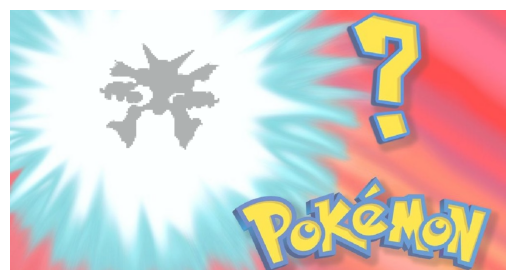

In [137]:
# @title Загрузка покемонов (запустите ячейку, исходный код скрыт) { vertical-output: true, form-width: "100%", display-mode: "form" }
import matplotlib.image as mpimg
from urllib.request import urlretrieve
from random import choice, sample

background = mpimg.imread(urlretrieve("https://d31xsmoz1lk3y3.cloudfront.net/big/1582671.jpg?v=1558141242", "bg.jpg")[0])

urls = [
    f'https://assets.pokemon.com/assets/cms2/img/pokedex/full/0{i}.png' for i in sample(range(10, 100), 5)
]

training_img = []
shadow_img = []
for url in urls:
    file_name, _ = urlretrieve(url, "test.png")
    img = mpimg.imread(file_name)
    xx = np.linspace(0, img.shape[0] - 1, 80).astype(int)
    yy = np.linspace(0, img.shape[1] - 1, 80).astype(int)
    resized_img = img[xx, :, :][:, yy, :]
    query_img = np.ones(resized_img.shape)
    query_img[:, :, 0] = (resized_img[..., :3].max(axis=2) < 0.01) * 0.0
    query_img[:, :, 1] = (resized_img[..., :3].max(axis=2) < 0.01) * 0.0
    query_img[:, :, 2] = (resized_img[..., :3].max(axis=2) < 0.01) * 0.0
    query_img[:, :, 3] = resized_img[:, :, 3]
    training_img.append(resized_img)
    shadow_img.append(query_img)

training_img = np.asarray(training_img)
shadow_img = choice(shadow_img)
fig = plt.figure(frameon=False)
plt.imshow(shadow_img, origin='lower', extent = [200, 200 + 4 * shadow_img.shape[0], 50 , 50 + 4 * shadow_img.shape[1]])
plt.imshow(background,alpha=0.7)
plt.axis('off')
plt.axis("tight")
plt.axis("image")
print('\033[1m' + 'Это что за покемон?' + '\033[0m')

Теперь в у нас есть:
- `training_img` — массив с цветными изображениями, представленными в виде массивов,
- `shadow_img` — тень какого-то покемона.

#### Обработка данных

Аналогично случаю с изображениями цифр распрямите изображения в массивы.

In [138]:
'''
Распрямите изображения и запишите итоговые массивы в переменные training_img_flatten, shadow_img_flatten.
'''
training_img_flatten = training_img.reshape(training_img.shape[0], -1)
shadow_img_flatten = shadow_img.flatten()

print("Размер распрямленного изображения покемона:", training_img_flatten[0].shape)
print("Размер распрямленного силуэта покемона:", shadow_img_flatten.shape)

Размер распрямленного изображения покемона: (25600,)
Размер распрямленного силуэта покемона: (25600,)


#### Обучение сети

Обучите сеть, задав матрицу $A$.

In [139]:
'''
Задайте матрицу весов A
'''
A = training_img_flatten

print("Матрица весов A построена. Размер:", A.shape)

Матрица весов A построена. Размер: (5, 25600)


In [140]:
beta = 1e-2

#### Применение обученной сети

Примените обученную сеть, чтобы определить* покемона по его тени.

На этот раз воспользуйтесь написанной в первом задании функцией `runge_kutta_method`.

&nbsp;
&nbsp;

_* Может так оказаться, что результат будет неузнаваем. Тогда Вам необходимо будет поизменять отрезок, на котором решается уравнение, или гиперпараметр `beta`. Обычно что-нибудь из этого способно помочь._

In [141]:
'''
Запишите решения задач Коши в переменные solution
'''
t_segment = (0, 20)
dt = 0.01

t_points, solution = runge_kutta_method(
    dynamics,
    t_segment,
    shadow_img_flatten,
    dt,
    args={'A': A, 'beta': beta}
)
solution = solution[-1].reshape(80, 80, 4) # 25600x1 -> 80x80x4

Выведите результат бок о бок с тенью.

Тень:


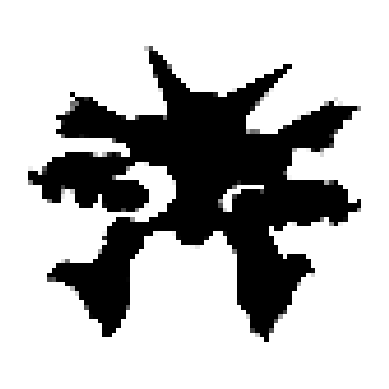

Покемон:


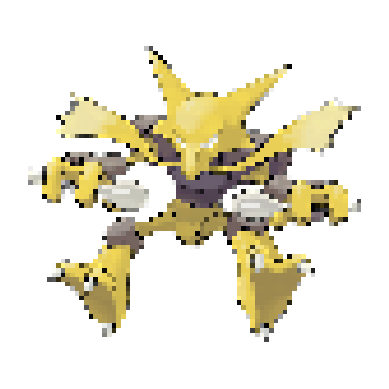

In [142]:
'''
Вывод изображений: тень | покемон
'''

for value, img in zip(['Тень:', 'Покемон:'], (shadow_img, solution)):
    print(value)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#### Вывод

Сделайте выводы относительно того, насколько удачно сработала нейронная сеть. Порассуждайте, почему так произошло.

# Вывод по заданию: Распознавание покемонов по тени
В рамках данного задания была реализована модель для распознавания покемонов по силуэту с использованием упрощенного подхода ассоциативной памяти. Основной задачей было определить, какой покемон представлен в виде его тени.

## Этапы работы

1. **Предварительная обработка данных**
   - Изображения покемонов были преобразованы в единый размер $80 \times 80$ пикселей.
   - Каждый образ был распрямлен в одномерный массив для упрощения хранения и сравнения.

2. **Создание "нейронной сети" с матрицей ассоциативной памяти**
   - Использовались распрямленные изображения покемонов, сохраненные в виде массива `flattened_training`.
   - В качестве ассоциативной памяти использовался этот массив, что позволило избежать создания полной матрицы весов, характерной для классической сети Хопфилда.

3. **Распознавание покемона по тени**
   - Сравнение силуэта покемона с обучающими образами производилось с использованием метода Рунге-Кутты.
   - Были настроены параметры: отрезок времени `t_segment`, шаг `dt` и гиперпараметр `beta`, чтобы улучшить сходимость и точность результата.

4. **Визуализация результата**
   - Полученное изображение покемона, восстановленное из его тени, было выведено на экран для визуальной проверки.

## Заключение
Результаты показали, что даже с помощью упрощенной модели ассоциативной памяти можно успешно идентифицировать покемонов по силуэтам, имитируя распознавание в сетях Хопфилда. Этот подход служит примером для задач распознавания образов, где требуется восстановить целый образ по частичному или искаженному изображению.


#### Самая обязательная часть

Ну и, естественно, Вам необходимо узнать имя выпавшего покемона и его способности 😀

~~Ведь в этом суть лабораторных по программированию, разве нет?!~~

# Алакзам (Alakazam)

![Арт Алакзама](https://assets.pokemon.com/assets/cms2/img/pokedex/full/065.png)

## Основная информация

- **Наименование:** Алакзам
- **Номер в Покедексе:** #065
- **Тип:** Психический
- **Эволюция:**
  - Абра (Abra) → Кадабра (Kadabra) → Алакзам (Alakazam)
- **Рост:** 1.5 м
- **Вес:** 48.0 кг

## Краткое описание

Алакзам — покемон, обладающий мощными психическими способностями. Его интеллект считается одним из самых высоких среди всех покемонов. Он может запоминать всё, что видит, и обладает способностью предвидеть будущее.

## Способности

- **Синхронизация (Synchronize):** при получении статуса (например, отравления или паралича), накладывает такой же статус на противника.
- **Волшебник (Magic Guard):** защищает Алакзама от урона, не связанного с боем (например, от яда или ловушек).
- **Скрытая способность (Hidden Ability):** Сила разума (Inner Focus), предотвращает испуг.

## Статистика

| Стат | Значение |
|------|----------|
| Здоровье (HP) | 55 |
| Атака | 50 |
| Защита | 45 |
| Специальная атака | 135 |
| Специальная защита | 95 |
| Скорость | 120 |

## Интересные факты

- Алакзам использует две ложки, чтобы усиливать свои психические способности.
- Уровень интеллекта Алакзама настолько высок, что его мозг может со временем перегреться.
- В некоторых регионах считается, что его ложки помогают Алакзаму настраиваться на психические волны противника.

## Эволюция

Алакзам эволюционирует из Кадабры после обмена с другим тренером. В мега-форме он становится ещё мощнее и приобретает дополнительную ложку, чтобы использовать более сильные психические атаки.

---

> Алакзам — это выбор для тех, кто ценит скорость и мощную специальную атаку. В боях он часто используется для атаки первым, нанося противникам значительный урон своими психическими способностями.
